## 1. Импорты

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F

## 1.1. Функция для визуализации метрик

In [16]:
def plot_metrics(train_losses, test_losses, train_accs, test_accs, title=''):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Train Loss')
    plt.plot(test_losses, 'g-', label='Test Loss')
    plt.title(f'{title}Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, 'b-', label='Train Accuracy')
    plt.plot(test_accs, 'g-', label='Test Accuracy')
    plt.title(f'{title}Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

## 2. Загрузка данных

In [17]:
torch.manual_seed(42)

data = torch.load('../data/Mushrooms_preprocessed.pt')
images = data['images']
labels = data['labels']
class_to_idx = data['class_to_idx']

print(f'Всего картинок: {len(images)}')
print(f'Индексы классов: {class_to_idx}')

Всего картинок: 6714
Индексы классов: {'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Hygrocybe': 5, 'Lactarius': 6, 'Russula': 7, 'Suillus': 8}


## 3. Подготовка датасета

In [18]:
dataset = TensorDataset(images, labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'train: {train_size}')
print(f'test: {test_size}')

train: 5371
test: 1343


## 4. Определение модели

In [19]:
class MushroomCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(MushroomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [20]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'устройство: {device}')

model = MushroomCNN(num_classes=9).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

устройство: mps
MushroomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## 5. Обучение

In [21]:
num_epochs = 10
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_epoch_loss = test_running_loss / len(test_loader)
    test_epoch_acc = 100 * test_correct / test_total
    test_losses.append(test_epoch_loss)
    test_accs.append(test_epoch_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.2f}%')

Epoch [1/10], Train Loss: 1.9665, Train Acc: 27.31%, Test Loss: 1.7814, Test Acc: 35.74%
Epoch [2/10], Train Loss: 1.7525, Train Acc: 37.44%, Test Loss: 1.6660, Test Acc: 41.10%
Epoch [3/10], Train Loss: 1.6051, Train Acc: 43.40%, Test Loss: 1.5452, Test Acc: 47.80%
Epoch [4/10], Train Loss: 1.4225, Train Acc: 50.14%, Test Loss: 1.5015, Test Acc: 49.14%
Epoch [5/10], Train Loss: 1.2183, Train Acc: 57.33%, Test Loss: 1.4828, Test Acc: 49.44%
Epoch [6/10], Train Loss: 0.9647, Train Acc: 66.52%, Test Loss: 1.6127, Test Acc: 48.70%
Epoch [7/10], Train Loss: 0.6966, Train Acc: 75.42%, Test Loss: 1.5942, Test Acc: 50.34%
Epoch [8/10], Train Loss: 0.4567, Train Acc: 83.63%, Test Loss: 1.9885, Test Acc: 49.22%
Epoch [9/10], Train Loss: 0.2994, Train Acc: 90.06%, Test Loss: 2.1433, Test Acc: 50.48%
Epoch [10/10], Train Loss: 0.2311, Train Acc: 92.18%, Test Loss: 2.3261, Test Acc: 48.99%


## 6. Визуализация результатов

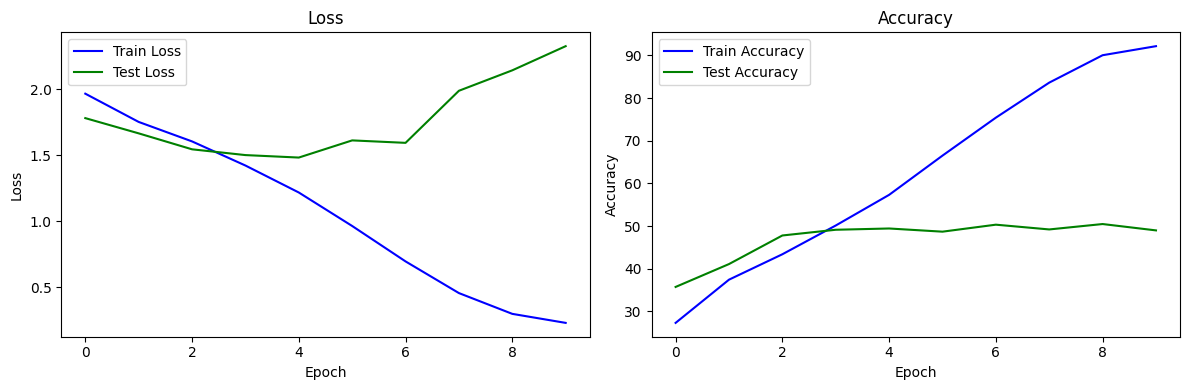

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Train Loss')
plt.plot(test_losses, 'g-', label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, 'b-', label='Train Accuracy')
plt.plot(test_accs, 'g-', label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Модель с BatchNorm, Dropout=0.3 и L2 регуляризацией

In [23]:
class MushroomCNN2(nn.Module):
    def __init__(self, num_classes=9):
        super(MushroomCNN2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model2 = MushroomCNN2(num_classes=9).to(device)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)

print(model2)

MushroomCNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [24]:
num_epochs = 10
train_losses2 = []
train_accs2 = []
test_losses2 = []
test_accs2 = []

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer2.zero_grad()
        outputs = model2(images)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses2.append(epoch_loss)
    train_accs2.append(epoch_acc)
    
    model2.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            loss = criterion2(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_epoch_loss = test_running_loss / len(test_loader)
    test_epoch_acc = 100 * test_correct / test_total
    test_losses2.append(test_epoch_loss)
    test_accs2.append(test_epoch_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.2f}%')

Epoch [1/10], Train Loss: 3.3374, Train Acc: 22.04%, Test Loss: 1.9044, Test Acc: 29.93%
Epoch [2/10], Train Loss: 1.9311, Train Acc: 28.60%, Test Loss: 1.8185, Test Acc: 33.80%
Epoch [3/10], Train Loss: 1.8501, Train Acc: 30.68%, Test Loss: 1.7450, Test Acc: 35.67%
Epoch [4/10], Train Loss: 1.8104, Train Acc: 33.25%, Test Loss: 1.7334, Test Acc: 35.96%
Epoch [5/10], Train Loss: 1.7727, Train Acc: 34.15%, Test Loss: 1.6714, Test Acc: 38.57%
Epoch [6/10], Train Loss: 1.7449, Train Acc: 34.44%, Test Loss: 1.7025, Test Acc: 38.12%
Epoch [7/10], Train Loss: 1.7353, Train Acc: 34.95%, Test Loss: 1.6770, Test Acc: 40.21%
Epoch [8/10], Train Loss: 1.6928, Train Acc: 37.03%, Test Loss: 1.6355, Test Acc: 41.33%
Epoch [9/10], Train Loss: 1.6706, Train Acc: 36.68%, Test Loss: 1.6881, Test Acc: 38.20%
Epoch [10/10], Train Loss: 1.6367, Train Acc: 38.76%, Test Loss: 1.6785, Test Acc: 40.06%


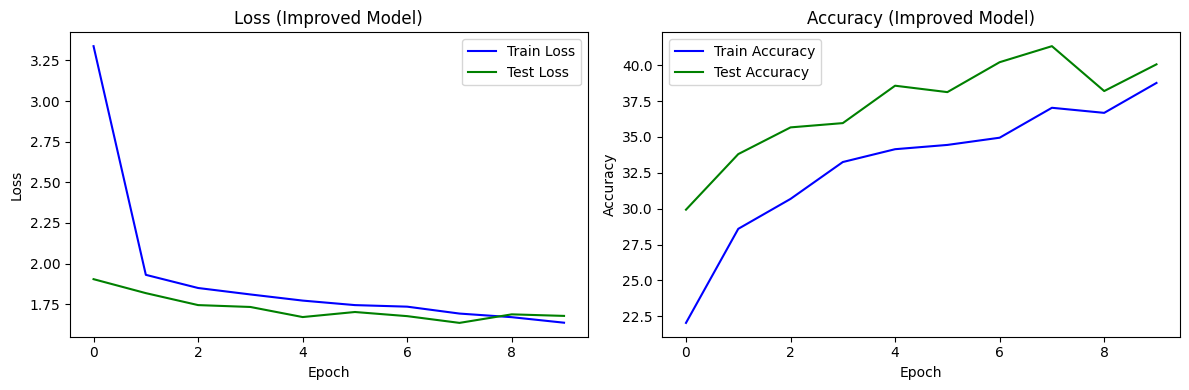

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses2, 'b-', label='Train Loss')
plt.plot(test_losses2, 'g-', label='Test Loss')
plt.title('Loss (Improved Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs2, 'b-', label='Train Accuracy')
plt.plot(test_accs2, 'g-', label='Test Accuracy')
plt.title('Accuracy (Improved Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 8. MushroomCNN2 с аугментированным датасетом (x2)

In [26]:
data_aug = torch.load('../data/Mushrooms_augmented_x2.pt')
images_aug = data_aug['images']
labels_aug = data_aug['labels']

print(f'Аугментированных картинок: {len(images_aug)}')

dataset_aug = TensorDataset(images_aug, labels_aug)

train_size_aug = int(0.8 * len(dataset_aug))
test_size_aug = len(dataset_aug) - train_size_aug
train_dataset_aug, test_dataset_aug = torch.utils.data.random_split(dataset_aug, [train_size_aug, test_size_aug])

train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=32, shuffle=False)

print(f'train: {train_size_aug}')
print(f'test: {test_size_aug}')

Аугментированных картинок: 13428
train: 10742
test: 2686


In [27]:
model3 = MushroomCNN2(num_classes=9).to(device)
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001, weight_decay=1e-4)

print(model3)

MushroomCNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [28]:
num_epochs = 10
train_losses3 = []
train_accs3 = []
test_losses3 = []
test_accs3 = []

for epoch in range(num_epochs):
    model3.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device)
        
        optimizer3.zero_grad()
        outputs = model3(images)
        loss = criterion3(outputs, labels)
        loss.backward()
        optimizer3.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader_aug)
    epoch_acc = 100 * correct / total
    train_losses3.append(epoch_loss)
    train_accs3.append(epoch_acc)
    
    model3.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader_aug:
            images, labels = images.to(device), labels.to(device)
            outputs = model3(images)
            loss = criterion3(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_epoch_loss = test_running_loss / len(test_loader_aug)
    test_epoch_acc = 100 * test_correct / test_total
    test_losses3.append(test_epoch_loss)
    test_accs3.append(test_epoch_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.2f}%')

Epoch [1/10], Train Loss: 2.7247, Train Acc: 22.96%, Test Loss: 1.9089, Test Acc: 28.63%
Epoch [2/10], Train Loss: 1.9512, Train Acc: 26.50%, Test Loss: 1.8792, Test Acc: 29.34%
Epoch [3/10], Train Loss: 1.9221, Train Acc: 27.29%, Test Loss: 1.8155, Test Acc: 30.38%
Epoch [4/10], Train Loss: 1.8886, Train Acc: 28.13%, Test Loss: 1.8472, Test Acc: 30.34%
Epoch [5/10], Train Loss: 1.8847, Train Acc: 28.20%, Test Loss: 1.8140, Test Acc: 30.42%
Epoch [6/10], Train Loss: 1.8663, Train Acc: 28.74%, Test Loss: 1.8238, Test Acc: 31.94%
Epoch [7/10], Train Loss: 1.8464, Train Acc: 29.24%, Test Loss: 1.8562, Test Acc: 29.56%
Epoch [8/10], Train Loss: 1.8309, Train Acc: 30.21%, Test Loss: 1.7905, Test Acc: 31.87%
Epoch [9/10], Train Loss: 1.8346, Train Acc: 29.67%, Test Loss: 1.7599, Test Acc: 34.03%
Epoch [10/10], Train Loss: 1.8058, Train Acc: 30.71%, Test Loss: 1.7522, Test Acc: 33.73%


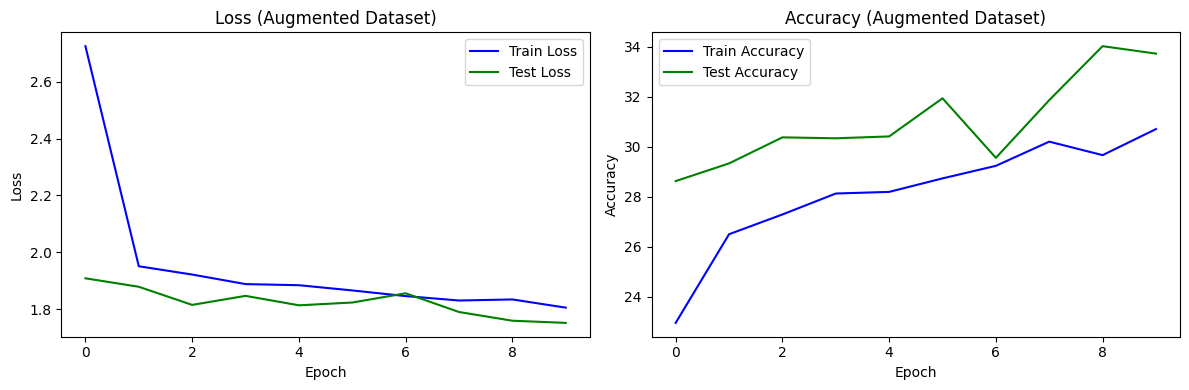

In [29]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses3, 'b-', label='Train Loss')
plt.plot(test_losses3, 'g-', label='Test Loss')
plt.title('Loss (Augmented Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs3, 'b-', label='Train Accuracy')
plt.plot(test_accs3, 'g-', label='Test Accuracy')
plt.title('Accuracy (Augmented Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 9. MushroomCNN2 с аугментированным датасетом (x7)

In [30]:
data_aug_x7 = torch.load('../data/Mushrooms_augmented_x7.pt')
images_aug_x7 = data_aug_x7['images']
labels_aug_x7 = data_aug_x7['labels']

print(f'Аугментированных картинок (x7): {len(images_aug_x7)}')

dataset_aug_x7 = TensorDataset(images_aug_x7, labels_aug_x7)

train_size_aug_x7 = int(0.8 * len(dataset_aug_x7))
test_size_aug_x7 = len(dataset_aug_x7) - train_size_aug_x7
train_dataset_aug_x7, test_dataset_aug_x7 = torch.utils.data.random_split(dataset_aug_x7, [train_size_aug_x7, test_size_aug_x7])

train_loader_aug_x7 = DataLoader(train_dataset_aug_x7, batch_size=32, shuffle=True)
test_loader_aug_x7 = DataLoader(test_dataset_aug_x7, batch_size=32, shuffle=False)

print(f'train: {train_size_aug_x7}')
print(f'test: {test_size_aug_x7}')

Аугментированных картинок (x7): 46998
train: 37598
test: 9400


In [31]:
model4 = MushroomCNN2(num_classes=9).to(device)
criterion4 = nn.CrossEntropyLoss()
optimizer4 = optim.Adam(model4.parameters(), lr=0.001, weight_decay=1e-4)

print(model4)

MushroomCNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [32]:
num_epochs = 10
train_losses4 = []
train_accs4 = []
test_losses4 = []
test_accs4 = []

for epoch in range(num_epochs):
    model4.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader_aug_x7:
        images, labels = images.to(device), labels.to(device)
        
        optimizer4.zero_grad()
        outputs = model4(images)
        loss = criterion4(outputs, labels)
        loss.backward()
        optimizer4.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader_aug_x7)
    epoch_acc = 100 * correct / total
    train_losses4.append(epoch_loss)
    train_accs4.append(epoch_acc)
    
    model4.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader_aug_x7:
            images, labels = images.to(device), labels.to(device)
            outputs = model4(images)
            loss = criterion4(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_epoch_loss = test_running_loss / len(test_loader_aug_x7)
    test_epoch_acc = 100 * test_correct / test_total
    test_losses4.append(test_epoch_loss)
    test_accs4.append(test_epoch_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.2f}%')

Epoch [1/10], Train Loss: 2.1869, Train Acc: 24.47%, Test Loss: 1.9177, Test Acc: 27.31%
Epoch [2/10], Train Loss: 1.8941, Train Acc: 28.29%, Test Loss: 1.8631, Test Acc: 30.04%
Epoch [3/10], Train Loss: 1.8591, Train Acc: 29.75%, Test Loss: 1.8311, Test Acc: 31.82%
Epoch [4/10], Train Loss: 1.8333, Train Acc: 30.84%, Test Loss: 1.7752, Test Acc: 35.02%
Epoch [5/10], Train Loss: 1.8097, Train Acc: 31.95%, Test Loss: 1.7428, Test Acc: 35.43%
Epoch [6/10], Train Loss: 1.7850, Train Acc: 32.59%, Test Loss: 1.7515, Test Acc: 36.76%
Epoch [7/10], Train Loss: 1.7649, Train Acc: 33.82%, Test Loss: 1.7020, Test Acc: 37.54%
Epoch [8/10], Train Loss: 1.7335, Train Acc: 35.56%, Test Loss: 1.6352, Test Acc: 41.28%
Epoch [9/10], Train Loss: 1.6810, Train Acc: 38.49%, Test Loss: 1.6604, Test Acc: 41.15%
Epoch [10/10], Train Loss: 1.6232, Train Acc: 40.85%, Test Loss: 1.6265, Test Acc: 41.41%


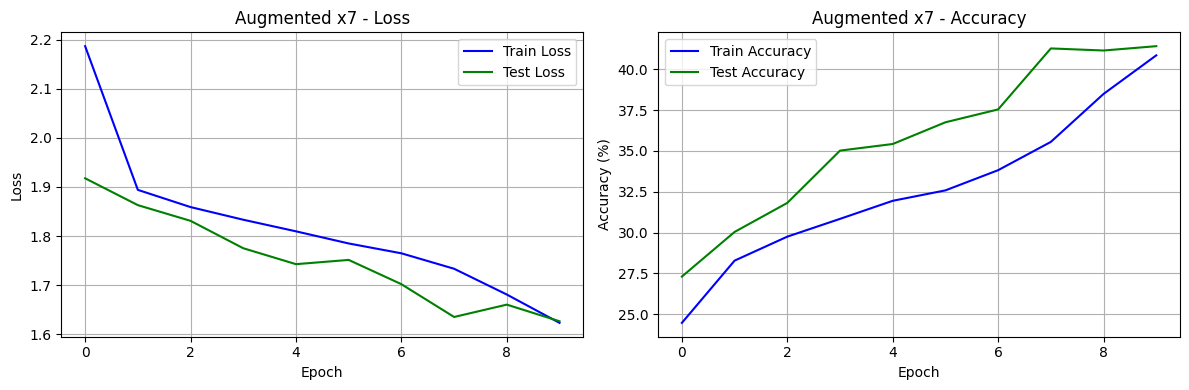

In [33]:
plot_metrics(train_losses4, test_losses4, train_accs4, test_accs4, 'Augmented x7 - ')

## 10. Сравнение Test Loss для MushroomCNN2 на разных датасетах

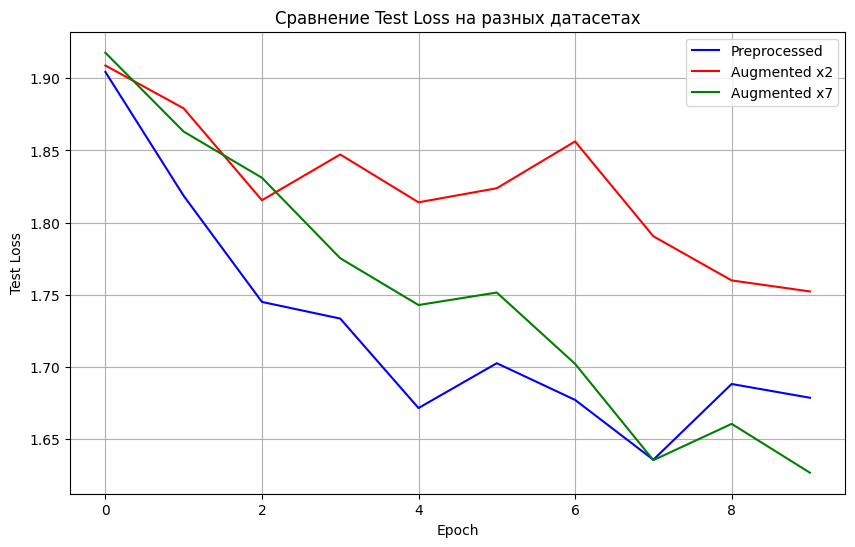

In [34]:
plt.figure(figsize=(10, 6))

plt.plot(test_losses2, 'b-', label='Preprocessed')
plt.plot(test_losses3, 'r-', label='Augmented x2')
plt.plot(test_losses4, 'g-', label='Augmented x7')

plt.title('Сравнение Test Loss на разных датасетах')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend()
plt.grid()
plt.show()

## 11. Эксперименты с 9 различными архитектурами CNN

### 11.1. Определение архитектур

In [35]:
# Удаляем большие датасеты чтобы освободить память
del data_aug, images_aug, labels_aug, dataset_aug, train_dataset_aug, test_dataset_aug, train_loader_aug, test_loader_aug
del data_aug_x7, images_aug_x7, labels_aug_x7, dataset_aug_x7, train_dataset_aug_x7, test_dataset_aug_x7, train_loader_aug_x7, test_loader_aug_x7
del model3, optimizer3, criterion3, model4, optimizer4, criterion4

import gc
gc.collect()

print('Память очищена')

Память очищена


In [36]:
# Arch1 - это MushroomCNN2 выше

# Arch2: 4 сверточных слоя
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(DeeperCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Arch3: Широкие каналы
class WiderCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(WiderCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 256 * 16 * 16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [37]:
# Arch4: Глубокая сеть (5 слоев)
class DeepWideCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(DeepWideCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        
        x = x.view(-1, 512 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Arch5: Мелкая сеть (2 слоя)
class ShallowCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(ShallowCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, 128 * 32 * 32)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Arch6: Много FC слоев
class DenseFCCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(DenseFCCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * 16 * 16, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn_fc3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(self.relu(self.bn_fc1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn_fc2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn_fc3(self.fc3(x))))
        x = self.fc4(x)
        return x

In [38]:
# Arch7: Больше Dropout
class HighDropoutCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(HighDropoutCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout_fc = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.pool(x)
        
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout_fc(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Arch8: Pooling не везде
class NoPoolMiddleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(NoPoolMiddleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(x)
        
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Arch9: VGG-style (парные conv)
class SmallKernelsCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SmallKernelsCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool(self.relu(self.bn6(self.conv6(x))))
        
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

### 11.2. Функция для обучения модели

In [39]:
def train_model(model, train_loader, test_loader, num_epochs=10, lr=0.001, weight_decay=1e-4, model_name='Model'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    print(f'\nОбучение {model_name}')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        test_epoch_loss = test_running_loss / len(test_loader)
        test_epoch_acc = 100 * test_correct / test_total
        test_losses.append(test_epoch_loss)
        test_accs.append(test_epoch_acc)
        
        print(f'Эпоха {epoch+1}/{num_epochs}: Train Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.2f}%, Test Loss={test_epoch_loss:.4f}, Test Acc={test_epoch_acc:.2f}%')
    
    print(f'Лучшая Test Acc: {max(test_accs):.2f}%')
    
    return train_losses, test_losses, train_accs, test_accs

### 11.3. Обучение всех 9 архитектур

In [40]:
models_list = [
    (MushroomCNN2(num_classes=9).to(device), 'Arch1: Baseline'),
    (DeeperCNN(num_classes=9).to(device), 'Arch2: Deeper'),
    (WiderCNN(num_classes=9).to(device), 'Arch3: Wider'),
    (DeepWideCNN(num_classes=9).to(device), 'Arch4: DeepWide'),
    (ShallowCNN(num_classes=9).to(device), 'Arch5: Shallow'),
    (DenseFCCNN(num_classes=9).to(device), 'Arch6: DenseFC'),
    (HighDropoutCNN(num_classes=9).to(device), 'Arch7: HighDropout'),
    (NoPoolMiddleCNN(num_classes=9).to(device), 'Arch8: NoPoolMiddle'),
    (SmallKernelsCNN(num_classes=9).to(device), 'Arch9: SmallKernels')
]

results = {}

for model, name in models_list:
    train_losses, test_losses, train_accs, test_accs = train_model(
        model, train_loader, test_loader, num_epochs=10, lr=0.001, weight_decay=1e-4, model_name=name
    )
    results[name] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'max_test_acc': max(test_accs),
        'max_test_epoch': test_accs.index(max(test_accs)) + 1,
        'final_test_acc': test_accs[-1]
    }
    
    del model
    gc.collect()

print('\nВсе архитектуры обучены!')


Обучение Arch1: Baseline
Эпоха 1/10: Train Loss=3.2242, Train Acc=25.69%, Test Loss=1.8095, Test Acc=34.85%
Эпоха 2/10: Train Loss=1.8618, Train Acc=33.23%, Test Loss=1.7554, Test Acc=36.19%
Эпоха 3/10: Train Loss=1.8137, Train Acc=34.13%, Test Loss=1.7273, Test Acc=38.64%
Эпоха 4/10: Train Loss=1.7547, Train Acc=36.49%, Test Loss=1.6577, Test Acc=40.21%
Эпоха 5/10: Train Loss=1.7047, Train Acc=38.26%, Test Loss=1.6477, Test Acc=41.25%
Эпоха 6/10: Train Loss=1.6644, Train Acc=39.55%, Test Loss=1.6553, Test Acc=41.10%
Эпоха 7/10: Train Loss=1.6144, Train Acc=40.92%, Test Loss=1.6353, Test Acc=42.89%
Эпоха 8/10: Train Loss=1.5744, Train Acc=42.79%, Test Loss=1.6395, Test Acc=42.59%
Эпоха 9/10: Train Loss=1.5309, Train Acc=44.41%, Test Loss=1.5615, Test Acc=46.31%
Эпоха 10/10: Train Loss=1.4822, Train Acc=45.45%, Test Loss=1.6155, Test Acc=43.11%
Лучшая Test Acc: 46.31%

Обучение Arch2: Deeper
Эпоха 1/10: Train Loss=2.7425, Train Acc=28.10%, Test Loss=1.7831, Test Acc=34.25%
Эпоха 2/10: 

### 11.4. Сравнительные графики для всех 9 архитектур

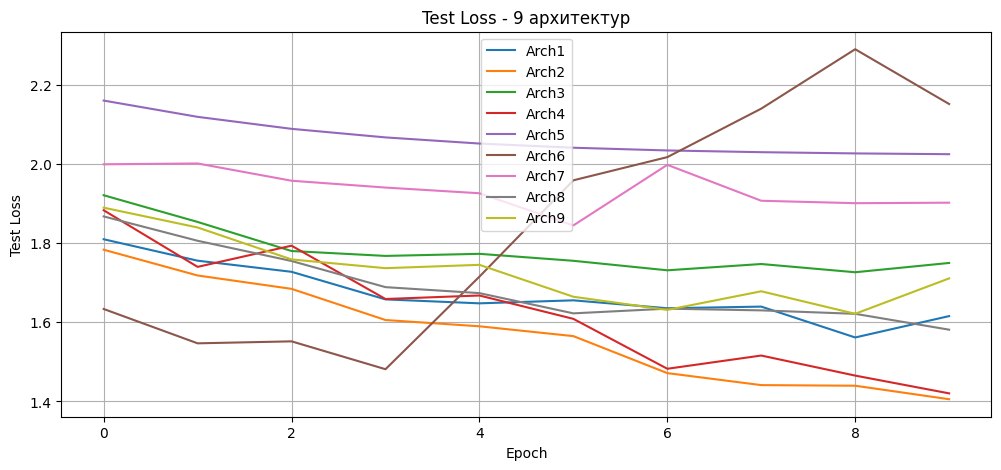

In [41]:
plt.figure(figsize=(12, 5))

for name, data in results.items():
    plt.plot(data['test_losses'], label=name.split(':')[0])

plt.title('Test Loss - 9 архитектур')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend()
plt.grid()
plt.show()

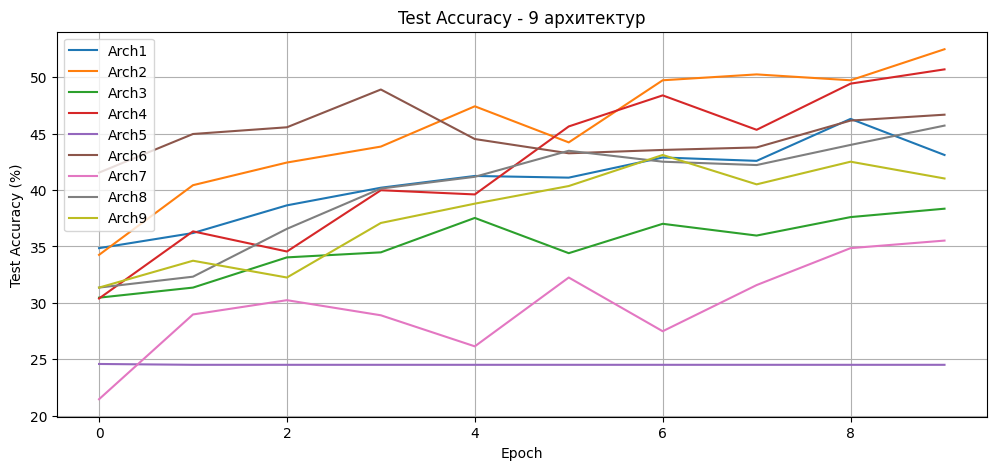

In [42]:
plt.figure(figsize=(12, 5))

for name, data in results.items():
    plt.plot(data['test_accs'], label=name.split(':')[0])

plt.title('Test Accuracy - 9 архитектур')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

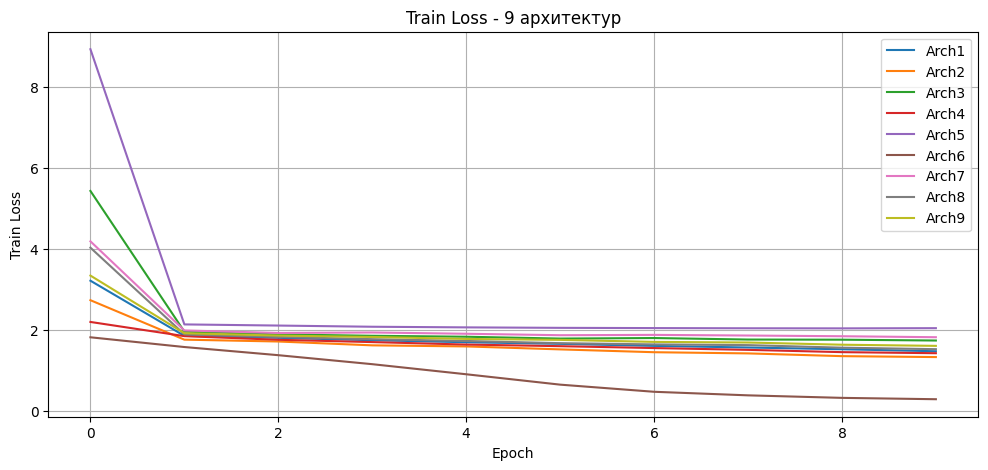

In [43]:
plt.figure(figsize=(12, 5))

for name, data in results.items():
    plt.plot(data['train_losses'], label=name.split(':')[0])

plt.title('Train Loss - 9 архитектур')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.grid()
plt.show()

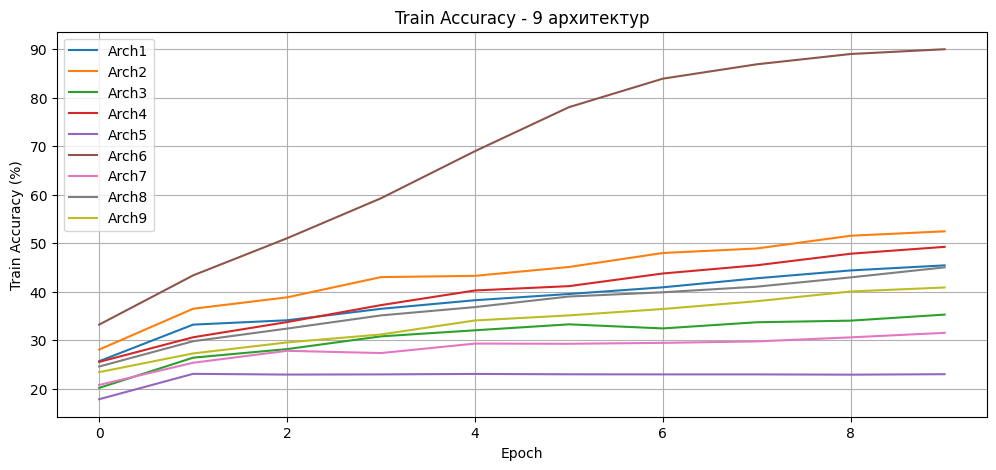

In [44]:
plt.figure(figsize=(12, 5))

for name, data in results.items():
    plt.plot(data['train_accs'], label=name.split(':')[0])

plt.title('Train Accuracy - 9 архитектур')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

## 12. Выбор топ-3 архитектур

In [45]:
import pandas as pd

results_table = []
for name, data in results.items():
    results_table.append({
        'Архитектура': name,
        'Max Test Acc': data['max_test_acc'],
        'Epoch': data['max_test_epoch'],
        'Final Test Acc': data['final_test_acc']
    })

df = pd.DataFrame(results_table)
df = df.sort_values('Max Test Acc', ascending=False)
print('Результаты:\n')
print(df.to_string(index=False))

top3_names = df.head(3)['Архитектура'].tolist()
print(f'\n\nТоп-3:')
for i, name in enumerate(top3_names, 1):
    print(f'{i}. {name} - {results[name]["max_test_acc"]:.2f}%')

Результаты:

        Архитектура  Max Test Acc  Epoch  Final Test Acc
      Arch2: Deeper     52.494415     10       52.494415
    Arch4: DeepWide     50.707372     10       50.707372
     Arch6: DenseFC     48.920328      4       46.686523
    Arch1: Baseline     46.314222      9       43.112435
Arch8: NoPoolMiddle     45.718541     10       45.718541
Arch9: SmallKernels     43.112435      7       41.027550
       Arch3: Wider     38.346984     10       38.346984
 Arch7: HighDropout     35.517498     10       35.517498
     Arch5: Shallow     24.571854      1       24.497394


Топ-3:
1. Arch2: Deeper - 52.49%
2. Arch4: DeepWide - 50.71%
3. Arch6: DenseFC - 48.92%


## 13. Финальное обучение топ-3 архитектур (50 эпох с LR scheduler)

In [48]:
def train_model_with_scheduler(model, train_loader, test_loader, num_epochs=50, lr=0.001, weight_decay=1e-4, model_name='Model'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    print(f'\nОбучение {model_name} (50 эпох)')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        test_epoch_loss = test_running_loss / len(test_loader)
        test_epoch_acc = 100 * test_correct / test_total
        test_losses.append(test_epoch_loss)
        test_accs.append(test_epoch_acc)
        
        scheduler.step(test_epoch_acc)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Эпоха {epoch+1}/{num_epochs}: Train Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.2f}%, Test Loss={test_epoch_loss:.4f}, Test Acc={test_epoch_acc:.2f}%')
    
    print(f'Лучшая Test Acc: {max(test_accs):.2f}%')
    
    return train_losses, test_losses, train_accs, test_accs

In [ ]:
model_classes = {
    'Arch1: Baseline': MushroomCNN2,
    'Arch2: Deeper': DeeperCNN,
    'Arch3: Wider': WiderCNN,
    'Arch4: DeepWide': DeepWideCNN,
    'Arch5: Shallow': ShallowCNN,
    'Arch6: DenseFC': DenseFCCNN,
    'Arch7: HighDropout': HighDropoutCNN,
    'Arch8: NoPoolMiddle': NoPoolMiddleCNN,
    'Arch9: SmallKernels': SmallKernelsCNN
}

final_results = {}

for name in top3_names:
    model_class = model_classes[name]
    model = model_class(num_classes=9).to(device)
    
    train_losses, test_losses, train_accs, test_accs = train_model_with_scheduler(
        model, train_loader, test_loader, num_epochs=50, lr=0.001, weight_decay=1e-4, model_name=name
    )
    
    final_results[name] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs
    }
    
    del model
    gc.collect()

print('\nТоп-3 обучены на 50 эпохах!')


Обучение Arch2: Deeper (50 эпох)
Эпоха 1/50: Train Loss=2.4530, Train Acc=26.74%, Test Loss=1.7617, Test Acc=34.77%
Эпоха 5/50: Train Loss=1.6783, Train Acc=39.02%, Test Loss=1.6345, Test Acc=42.81%
Эпоха 10/50: Train Loss=1.4139, Train Acc=49.13%, Test Loss=1.5124, Test Acc=47.51%
Эпоха 15/50: Train Loss=1.1855, Train Acc=56.56%, Test Loss=1.4833, Test Acc=51.53%
Эпоха 20/50: Train Loss=0.9641, Train Acc=63.94%, Test Loss=1.4098, Test Acc=54.28%
Эпоха 25/50: Train Loss=0.7170, Train Acc=72.67%, Test Loss=1.5000, Test Acc=55.70%
Эпоха 30/50: Train Loss=0.4591, Train Acc=82.61%, Test Loss=1.6798, Test Acc=59.42%
Эпоха 35/50: Train Loss=0.3263, Train Acc=87.67%, Test Loss=1.8113, Test Acc=58.67%
Эпоха 40/50: Train Loss=0.2523, Train Acc=90.08%, Test Loss=2.0051, Test Acc=58.90%
Эпоха 45/50: Train Loss=0.1866, Train Acc=92.87%, Test Loss=2.1893, Test Acc=58.90%
Эпоха 50/50: Train Loss=0.1622, Train Acc=94.17%, Test Loss=2.1983, Test Acc=59.94%
Лучшая Test Acc: 59.94%

Обучение Arch4: Dee

### 13.1. Сравнительные графики топ-3 моделей

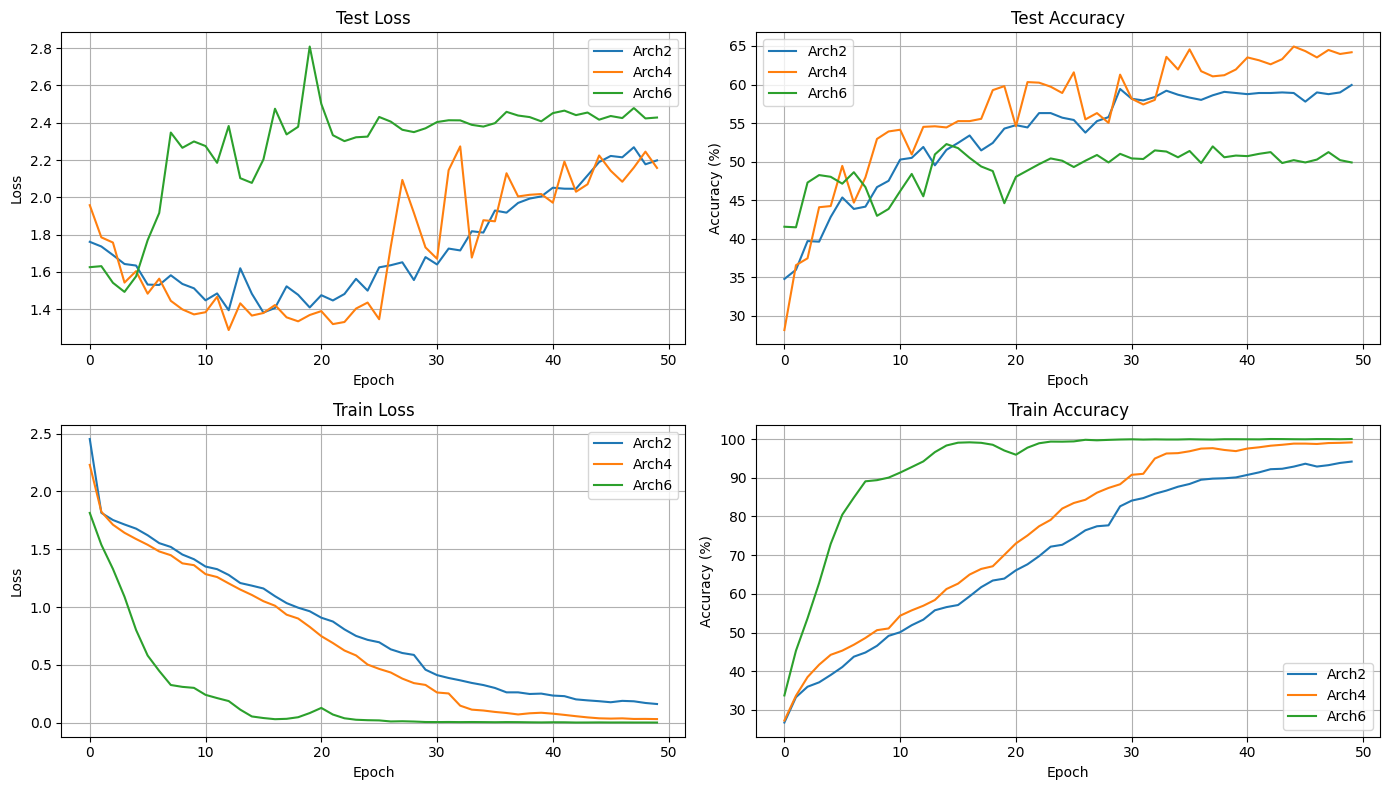

In [50]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
for name, data in final_results.items():
    plt.plot(data['test_losses'], label=name.split(':')[0])
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
for name, data in final_results.items():
    plt.plot(data['test_accs'], label=name.split(':')[0])
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
for name, data in final_results.items():
    plt.plot(data['train_losses'], label=name.split(':')[0])
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
for name, data in final_results.items():
    plt.plot(data['train_accs'], label=name.split(':')[0])
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Выводы по топ-3 моделям

Arch2 (Deeper): 59.94% - стабильная, но переобучается (94% train)

Arch4 (DeepWide): 64.93% - лучший результат, но сильно переобучается (99% train)

Arch6 (DenseFC): 52.27% (пик на 15 эпохе) - слишком много FC слоёв, катастрофическое переобучение (100% train)

Вывод: для грибов нужна глубина (4-5 conv слоёв), но FC слои нужно делать компактнее

## 14. Объединённая модель (лучшее от топ-3)

In [54]:
# Объединяем идеи:
# - 5 conv слоёв от Arch4 (глубина)
# - Каналы 32->64->128->256->512 (баланс между Arch2 и Arch4)
# - 2 FC слоя с BatchNorm от Arch6 (не 4!)
# - Агрессивная регуляризация (dropout 0.5-0.6)

class CombinedCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(CombinedCNN, self).__init__()
        
        # 5 conv блоков (глубина от Arch4)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.3)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.4)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(0.4)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.dropout5 = nn.Dropout(0.5)
        
        # 2 FC слоя с BatchNorm (компактнее чем у Arch6)
        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.6)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout5(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)
        return x

model_combined = CombinedCNN(num_classes=9).to(device)
print(f'Параметров в CombinedCNN: {sum(p.numel() for p in model_combined.parameters()):,}')

Параметров в CombinedCNN: 5,900,553


In [55]:
# Обучаем 50 эпох с weight_decay=5e-4 (больше регуляризации)
train_losses_combined, test_losses_combined, train_accs_combined, test_accs_combined = train_model_with_scheduler(
    model_combined, train_loader, test_loader, num_epochs=50, lr=0.001, weight_decay=5e-4, model_name='Combined'
)

final_results['Combined'] = {
    'train_losses': train_losses_combined,
    'test_losses': test_losses_combined,
    'train_accs': train_accs_combined,
    'test_accs': test_accs_combined
}

del model_combined
gc.collect()

print('\nCombined модель обучена!')


Обучение Combined (50 эпох)
Эпоха 1/50: Train Loss=1.9850, Train Acc=26.51%, Test Loss=1.9035, Test Acc=29.64%
Эпоха 5/50: Train Loss=1.5554, Train Acc=44.87%, Test Loss=1.6817, Test Acc=38.05%
Эпоха 10/50: Train Loss=1.3479, Train Acc=52.84%, Test Loss=1.4172, Test Acc=51.08%
Эпоха 15/50: Train Loss=1.2232, Train Acc=56.90%, Test Loss=1.3543, Test Acc=53.61%
Эпоха 20/50: Train Loss=0.9735, Train Acc=66.64%, Test Loss=1.1519, Test Acc=61.73%
Эпоха 25/50: Train Loss=0.8601, Train Acc=70.88%, Test Loss=1.1658, Test Acc=61.21%
Эпоха 30/50: Train Loss=0.7517, Train Acc=73.67%, Test Loss=1.1845, Test Acc=60.61%
Эпоха 35/50: Train Loss=0.5693, Train Acc=80.45%, Test Loss=1.0889, Test Acc=66.57%
Эпоха 40/50: Train Loss=0.5060, Train Acc=83.00%, Test Loss=1.1670, Test Acc=63.74%
Эпоха 45/50: Train Loss=0.3885, Train Acc=87.10%, Test Loss=1.1632, Test Acc=64.85%
Эпоха 50/50: Train Loss=0.3476, Train Acc=88.49%, Test Loss=1.2071, Test Acc=65.30%
Лучшая Test Acc: 66.57%

Combined модель обучена!

### Сравнение всех 4 моделей (топ-3 + Combined)

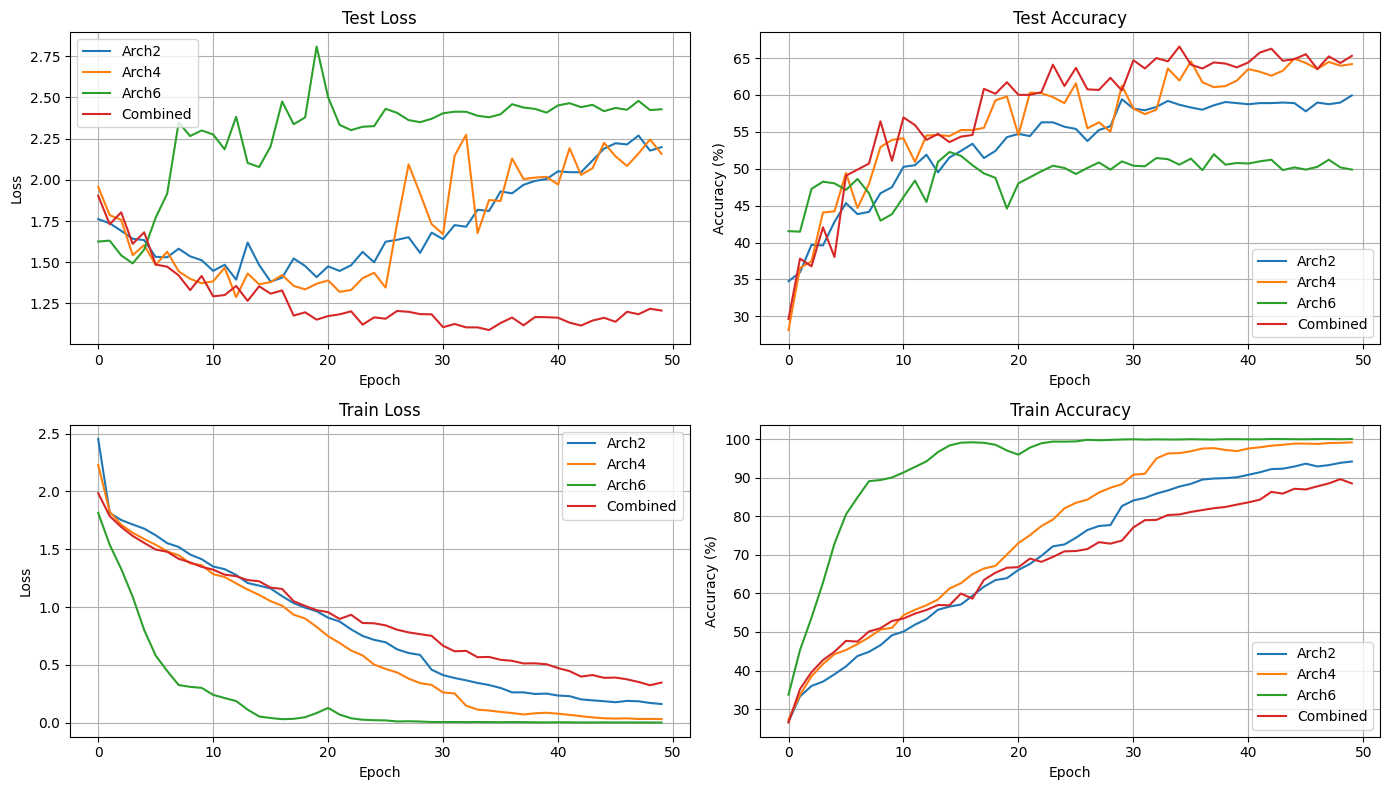

In [56]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
for name, data in final_results.items():
    plt.plot(data['test_losses'], label=name.split(':')[0])
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
for name, data in final_results.items():
    plt.plot(data['test_accs'], label=name.split(':')[0])
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
for name, data in final_results.items():
    plt.plot(data['train_losses'], label=name.split(':')[0])
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
for name, data in final_results.items():
    plt.plot(data['train_accs'], label=name.split(':')[0])
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [57]:
# Итоговые результаты всех 4 моделей
print('Итоговые результаты (макс Test Accuracy):')
for name, data in final_results.items():
    max_acc = max(data['test_accs'])
    max_epoch = data['test_accs'].index(max_acc) + 1
    final_acc = data['test_accs'][-1]
    print(f'{name}: Max={max_acc:.2f}% (эп. {max_epoch}), Final={final_acc:.2f}%')

Итоговые результаты (макс Test Accuracy):
Arch2: Deeper: Max=59.94% (эп. 50), Final=59.94%
Arch4: DeepWide: Max=64.93% (эп. 45), Final=64.18%
Arch6: DenseFC: Max=52.27% (эп. 15), Final=49.89%
Combined: Max=66.57% (эп. 35), Final=65.30%
